In [2]:
import pandas, seaborn, scipy, numpy, matplotlib, sklearn, collections, itertools, math, functools, sys

%matplotlib inline
from matplotlib import pyplot
matplotlib.rc("savefig", dpi=800)
#matplotlib.rc("savefig", dpi=72)

from sklearn import preprocessing

# Constants
library_sizes = {
    'WGS': 3002000000,
    'WES': 50160183,
}
mhc_binding_threshold_affinity = 500

def bootstrap(values, statistic=numpy.mean, samples=5000):
    values = pandas.Series(values).dropna()
    if len(values) <= 1:
        return (numpy.nan, numpy.nan)
    values = [statistic(sklearn.utils.resample(values)) for i in range(samples)]
    return (numpy.percentile(values, 5), numpy.percentile(values, 95))

def round_to_n(x, n):
    return round(x, -int(math.floor(math.log10(x))) + (n - 1)) 

def mean_with_errorbars(values, decimals=0):
    pattern = "%%0.%df" % decimals
    bars = bootstrap(values)
    if numpy.nan in bars:
        return pattern % numpy.mean(values)
    if decimals == 0:
        bars = (round_to_n(bars[0], 2), round_to_n(bars[1], 2)) 
    return (pattern + " (" + pattern + " - " + pattern + ")") % ((numpy.mean(values),) + bars)

pandas.set_option('display.max_columns', 500)


def print_full(x):
    pandas.set_option('display.max_rows', len(x))
    print(x)
    pandas.reset_option('display.max_rows')

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
#seaborn.lmplot(data=df, x="percentage_cellularity", y="mutations", hue="tissue_type")

In [4]:
predicted = ["mutations", "peptides", "expressed peptides"]

# donor is handled specially
predictors = [
    "treated",
    "timepoint",
#    "metastasis",
#    "specimen_interval",
    "tissue_type",
#    "tumour_grade",
#    "tumour_stage",
    "percentage_cellularity"
]

In [5]:
df = pandas.read_csv("../data/sources.extended.csv", index_col="source_id")
df = df.ix[~pandas.isnull(df.mutations)]
df

def make_data(y_column):
    stan_df = df[[y_column, "donor"] + predictors].copy()
    stan_df.columns = ["y"] + list(stan_df.columns[1:])
    #stan_df["y"] = numpy.log(stan_df["y"])
    original_donors = stan_df.donor
    stan_df["low_cellularity"] = stan_df.percentage_cellularity < stan_df.dropna().percentage_cellularity.quantile(.25)
    del stan_df["percentage_cellularity"]
    stan_df["recurrence"] = stan_df["timepoint"] == "recurrence"
    del stan_df["timepoint"]

    stan_df["ascites"] = stan_df["tissue_type"] == "ascites"
    del stan_df["tissue_type"]
    
    stan_df["num_sources_for_donor"] = pandas.Series(
        [(original_donors == donor).sum() for donor in original_donors],
        index=original_donors.index)

    stan_df = stan_df.dropna()
    stan_df["donor"] = stan_df.donor.astype('category').values.codes
    #stan_df["solid and treated"] = (~stan_df.ascites) & (stan_df.treated)
    return stan_df

data_by_predicted = collections.OrderedDict()
for col in predicted:
    data_by_predicted[col] = make_data(col)
    print(col, data_by_predicted[col].shape)
data_by_predicted["mutations"].head()

('mutations', (115, 7))
('peptides', (115, 7))
('expressed peptides', (98, 7))


,y,donor,treated,low_cellularity,recurrence,ascites,num_sources_for_donor
source_id,,,,,,,
AOCS-001-1/SP101515,5937,0,False,True,False,False,1
AOCS-002-1/SP101517,1532,1,False,False,False,False,1
AOCS-004-1/SP101519,6786,2,False,True,False,False,1
AOCS-005-1/SP101521,5703,3,False,False,False,False,1
AOCS-034-13/SP101524,13626,4,True,False,True,True,2


In [6]:
import pystan, time
FIT_CACHE={}
def run_stan(model_code, *args, **kwargs):
    kwargs = dict(kwargs)
    kwargs['model_code'] = model_code
    if 'n_jobs' not in kwargs:
        kwargs['n_jobs'] = -1
    if model_code in FIT_CACHE:
        print("Reusing fit.")
        kwargs['fit'] = FIT_CACHE[model_code]
    else:
        print("NOT reusing fit.")
    start = time.time()
    FIT_CACHE[model_code] = pystan.stan(*args, **kwargs)
    print("Ran in %0.3f sec." % (time.time() - start))
    return FIT_CACHE[model_code]



In [7]:
# stan model
model1 = """
functions {
  /* 
    ## per : https://groups.google.com/forum/?fromgroups#!searchin/stan-users/neg_binomial_2_log_rng/stan-users/rgpHgBtFS3k/A7GqglKOAQAJ
    ## neg_binomial_2_rng(mu,psi) as suggested by Ben: 
    real gamma_temp; 
    if (is_inf(psi)) 
      gamma_temp <- mu; 
    else 
      gamma_temp <- gamma_rng(psi, psi / mu); 
    if (gamma_temp < pow(2.0, 30.0)) 
      result <- poisson_rng(gamma_temp); 
    else 
      result <- normal_rng(gamma_temp, sqrt(gamma_temp)); 
  */
  real alt_neg_binom_2_rng(real mu, real psi) {
    real gamma_temp; 
    real result;
    
    if (is_nan(psi)) 
      gamma_temp <- mu;
    else if (is_inf(psi)) 
      gamma_temp <- mu; 
    else if (is_nan(psi / mu))
      gamma_temp <- mu;
    else if (is_inf(psi / mu))
      gamma_temp <- mu;
    else if (psi / mu < 0)
      gamma_temp <- mu;
    else 
      gamma_temp <- gamma_rng(psi, psi / mu);
      
    if (is_nan(gamma_temp) || is_inf(gamma_temp) || gamma_temp < 0)
      result <- -1;
    else if (gamma_temp < pow(2.0, 30.0)) 
      result <- poisson_rng(gamma_temp);
    else 
      result <- normal_rng(gamma_temp, sqrt(gamma_temp)); 
    
    if (result > 2^31) {
      result <- 2^31;
    }
    
    return floor(result);
  }
}
data {
    // Data sizes
    int<lower=0> num_sources;
    int<lower=0> num_predictors;
    int<lower=0> num_donors;

    // Data
    vector[num_predictors] predictors[num_sources];
    int<lower=0> donors[num_sources];
    int y[num_sources];  // predicted variable
    int<lower=1> num_sources_for_donor[num_sources];
}
parameters {
    real global_mean;
    real<lower=0> donor_sigma;
    real<lower=0> phi;
    vector[num_donors] donor_mean;    
    vector[num_predictors] predictor_coefficients;
}
transformed parameters {
    real lp;
    real mu[num_sources];
    
    for (i in 1:num_sources) {
        lp <- dot_product(predictors[i], predictor_coefficients);
        if (num_sources_for_donor[i] > 1) {
            mu[i] <- donor_mean[donors[i]] + lp;
        } else {
            mu[i] <- global_mean + lp;
        }
    }
}
model {
    global_mean ~ normal(0, 100);
    donor_sigma ~ cauchy(0, 2);
    phi ~ cauchy(0, 2);
    donor_mean ~ normal(global_mean, donor_sigma);
    predictor_coefficients ~ normal(0, 20);
    if (!is_inf(phi) && phi > machine_precision())
        y ~ neg_binomial_2_log(mu, phi);    
}
generated quantities {
    real y_rep[num_sources];
    real log_lik[num_sources];
    
    
    for (i in 1:num_sources) {
        if (!is_inf(phi) 
            && phi > machine_precision() 
            && !is_inf(mu[i]) 
            && exp(mu[i]) <= 2^29 
            && exp(mu[i])/phi > machine_precision()) 
            {
                  y_rep[i] <- alt_neg_binom_2_rng(exp(mu[i]), phi);
                  log_lik[i] <- neg_binomial_2_log_log(y[i], mu[i], phi);
        } else {
          y_rep[i] <- 0;
          log_lik[i] <- 0;
        }
    }
}
""".strip()

data = {    

}
def init(data):
    return {
        'global_mean': 0.0,
        'donor_sigma': 1.0,
        'phi': 1.0,
        'donor_mean': numpy.zeros(data['num_donors']),
        'predictor_coefficients': numpy.random.normal(0, .1, size=(data['num_predictors'],)),
    }

for (i, line) in enumerate(model1.split("\n")):
    print("%3d %s" % (i + 1, line))

def print_dict(d):
    for key in [key for key in d if not isinstance(d[key], numpy.ndarray)]:
        print("%s: %s" % (key, d[key]))
    for key in [key for key in d if isinstance(d[key], numpy.ndarray)]:
        print("%s: %s mean=%s std=%s" % (key,  d[key].shape, d[key].mean(), d[key].std()))

fit_results = {}
for (y_label, raw_data) in data_by_predicted.items():
    print("+" * 40)
    print("RUNNING MODEL FOR: %s" % y_label)
    df_x = raw_data[[x for x in list(raw_data.columns) if x not in ("y", "donor")]].astype(float)
    data = {
        'num_sources': len(raw_data.index),
        'num_predictors': len(df_x.columns),
        'num_donors': raw_data.donor.nunique(),

        'predictors': df_x.values.astype(float),
        'donors': raw_data.donor.values + 1,  # convert to 1-indexed
        'num_sources_for_donor': raw_data.num_sources_for_donor.values,
        'y': raw_data.y.astype(int).values,
    }
    print("")
    print("*" * 40)
    print("DATA")
    print_dict(data)
    print("")

    print("*" * 40)
    print("INITIAL VALUES")
    print_dict(init(data))
    sys.stdout.flush()
    
    fit_results[y_label] = run_stan(model_code=model1, data=data, init=lambda: init(data), iter=10000, chains=2)
    print("Done with fit.")
print("DONE")


  1 functions {
  2   /* 
  3     ## per : https://groups.google.com/forum/?fromgroups#!searchin/stan-users/neg_binomial_2_log_rng/stan-users/rgpHgBtFS3k/A7GqglKOAQAJ
  4     ## neg_binomial_2_rng(mu,psi) as suggested by Ben: 
  5     real gamma_temp; 
  6     if (is_inf(psi)) 
  7       gamma_temp <- mu; 
  8     else 
  9       gamma_temp <- gamma_rng(psi, psi / mu); 
 10     if (gamma_temp < pow(2.0, 30.0)) 
 11       result <- poisson_rng(gamma_temp); 
 12     else 
 13       result <- normal_rng(gamma_temp, sqrt(gamma_temp)); 
 14   */
 15   real alt_neg_binom_2_rng(real mu, real psi) {
 16     real gamma_temp; 
 17     real result;
 18     
 19     if (is_nan(psi)) 
 20       gamma_temp <- mu;
 21     else if (is_inf(psi)) 
 22       gamma_temp <- mu; 
 23     else if (is_nan(psi / mu))
 24       gamma_temp <- mu;
 25     else if (is_inf(psi / mu))
 26       gamma_temp <- mu;
 27     else if (psi / mu < 0)
 28       gamma_temp <- mu;
 29     else 
 30       gamma_temp <- gamma_rn

In [12]:
all_fit_coefficients = []
for (y_label, fit) in fit_results.items():
    extracted = fit.extract()
    fit_coefficients = pandas.DataFrame(numpy.exp(extracted['predictor_coefficients']),
                           columns=list(data_by_predicted[y_label].columns)[2:])
    fit_coefficients["y_label"] = y_label
    all_fit_coefficients.append(fit_coefficients)
all_fit_coefficients = pandas.concat(all_fit_coefficients, ignore_index=True)
all_fit_coefficients.head()

,treated,low_cellularity,recurrence,ascites,num_sources_for_donor,y_label
0,1.304656,1.004163,0.767084,2.101450,1.325923,peptides
1,1.401483,1.187336,0.767954,1.393171,1.469617,peptides
2,1.284298,0.841129,1.308192,1.052430,0.956744,peptides
3,1.048791,1.028820,1.632988,0.918111,1.353336,peptides
4,1.282660,0.958560,0.834379,1.788840,1.144024,peptides


#### plot coefficient values by outcome type

In [13]:
melted = pandas.melt(all_fit_coefficients, id_vars=["y_label"])

In [14]:
1 - (all_fit_coefficients.treated <= 1.05).mean()

0.22876666666666667

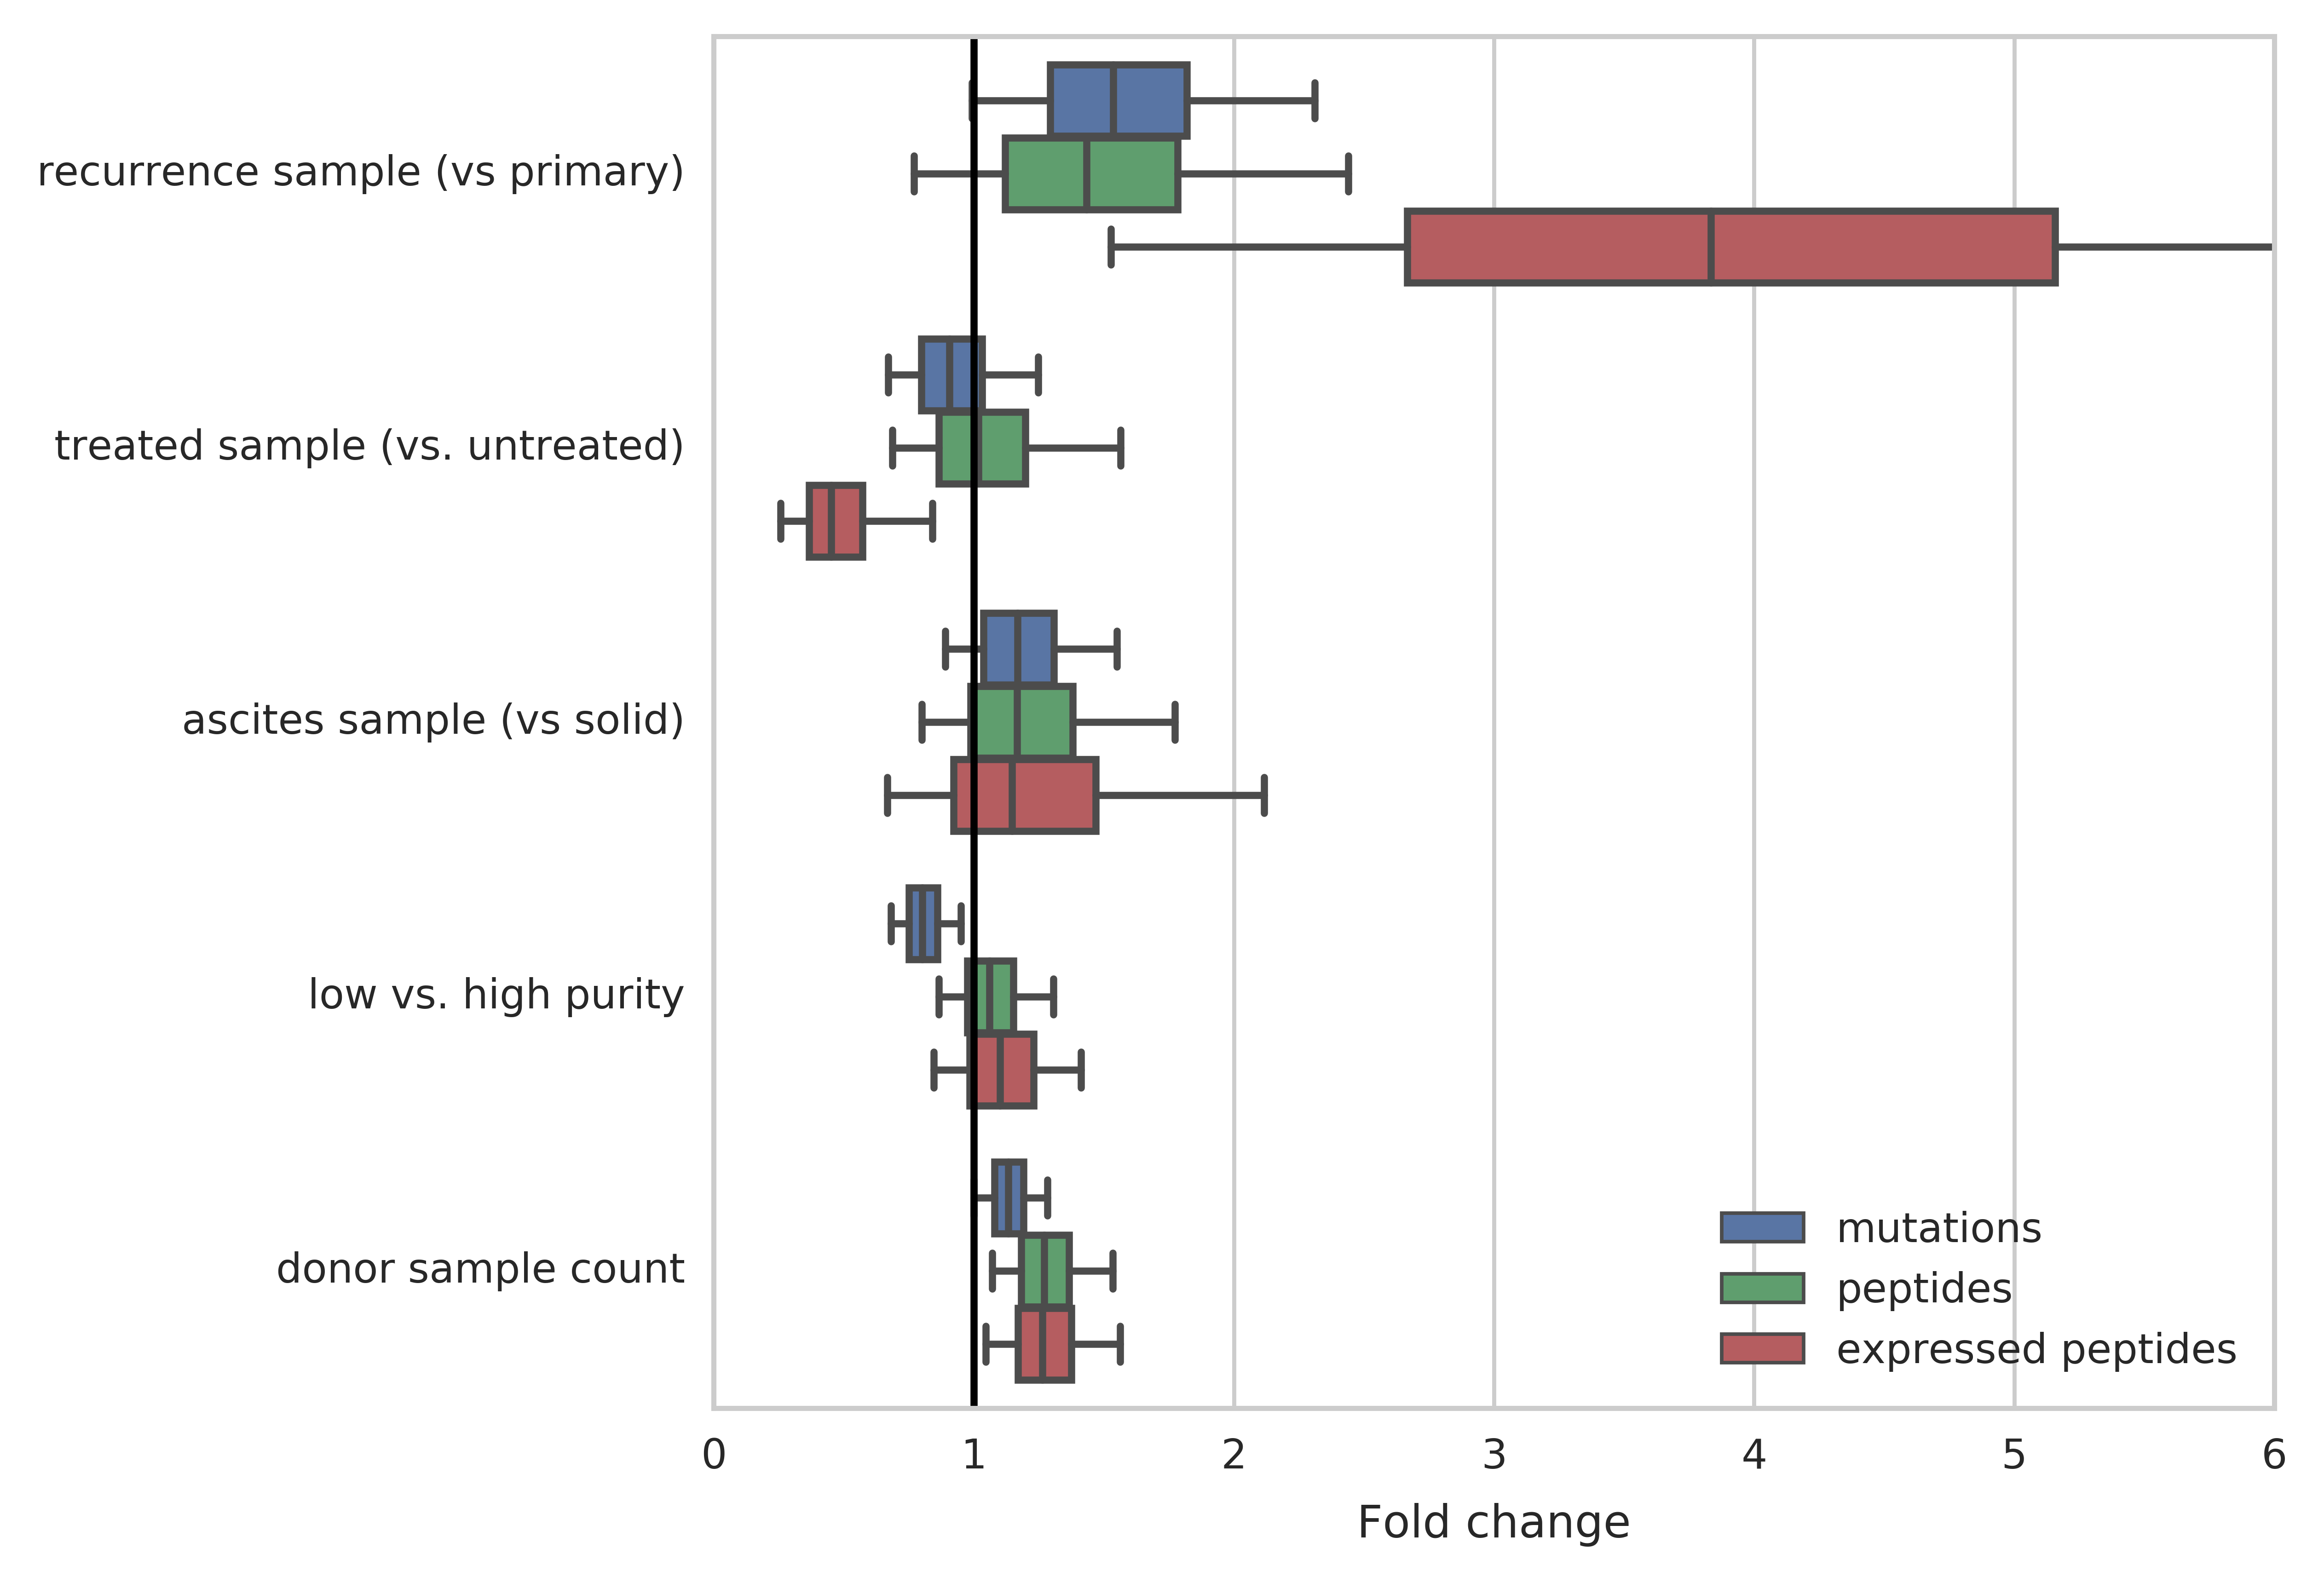

In [11]:
nice_melted = melted.copy()
nice_melted.variable = nice_melted.variable.map(lambda x: {
        "low_cellularity": "low purity",
        "num_sources_for_donor": "donor sample count"
}.get(x, x))
renames = {
    'treated': 'treated sample (vs. untreated)',
    'solid': 'solid vs. ascites tumor',
    'ascites': 'ascites sample (vs solid)',
    'low purity': 'low vs. high purity',
    'solid and treated': 'interaction:\nsolid tumor + treated',
    'donor sample count': 'donor sample count',
    'recurrence': 'recurrence sample (vs primary)'
}
nice_melted.variable = nice_melted.variable.map(renames)

seaborn.set_context('paper')
seaborn.set_style("whitegrid")
seaborn.boxplot(
    data=nice_melted,
    y='variable',
    x='value',
    hue='y_label',
    order=[renames.get(x, x) for x in ["recurrence", "treated", "ascites", "low purity", "donor sample count"]],
    hue_order=["mutations", "peptides", "expressed peptides"],
    whis=[5, 95],
    orient='h',
    showbox=True,
    showfliers=False,
#    meanline=True,
#    showmeans=True
)
pyplot.xlim(xmin=0,xmax=6)
pyplot.ylabel("")
pyplot.xlabel("Fold change")
pyplot.legend(title=None, loc='lower right')
pyplot.axvline(1.0, color="black")
pyplot.tight_layout()
#pyplot.savefig("../figures/bayesian_model_effects.pdf")